In [1]:
from scipy.stats import ttest_ind
import helper 
import xarray as xr 
import numpy as np 
import cmaps as cmap 
import matplotlib.pyplot as plt
import scipy 
import warnings
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe
warnings.filterwarnings("ignore")

dataset1 = r"C:\Users\deela\Downloads\tc_radar_v3m_1997_2019_xy_rel_swath_ships.nc"
dataset2 = r"C:\Users\deela\Downloads\tc_radar_v3m_2020_2024_xy_rel_swath_ships.nc"
dataset = xr.open_mfdataset([dataset1,dataset2], concat_dim='num_cases', combine='nested')

In [2]:
print(dataset, list(dataset.variables))

<xarray.Dataset> Size: 316GB
Dimensions:                                         (num_cases: 1510,
                                                     latitude: 200,
                                                     longitude: 200,
                                                     northward_distance: 201,
                                                     eastward_distance: 201,
                                                     height: 37,
                                                     ships_lag_times: 17)
Coordinates:
  * num_cases                                       (num_cases) float32 6kB 0...
  * height                                          (height) float32 148B 0.0...
  * ships_lag_times                                 (ships_lag_times) float32 68B ...
  * eastward_distance                               (eastward_distance) float32 804B ...
  * northward_distance                              (northward_distance) float32 804B ...
Dimensions without coordinates

In [ ]:
data = dataset['swath_wind_speed']
print(data)

<xarray.DataArray 'swath_wind_speed' (num_cases: 1510, latitude: 200,
                                      longitude: 200, height: 37)> Size: 9GB
dask.array<concatenate, shape=(1510, 200, 200, 37), dtype=float32, chunksize=(134, 34, 34, 5), chunktype=numpy.ndarray>
Coordinates:
  * num_cases  (num_cases) float32 6kB 0.0 1.0 2.0 3.0 ... 797.0 798.0 799.0
  * height     (height) float32 148B 0.0 0.5 1.0 1.5 2.0 ... 16.5 17.0 17.5 18.0
Dimensions without coordinates: latitude, longitude
Attributes:
    units:      m s**-1
    long_name:  storm-relative horizontal wind speed in the original analysis...


In [4]:
print(data.longitude)

<xarray.DataArray 'longitude' (longitude: 200)> Size: 2kB
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 1

In [5]:
x = data.longitude.values * 2
xCenter = np.nanmean(x)
y = data.latitude.values * 2
yCenter = np.nanmean(y)

X, Y = np.meshgrid(x, y, indexing = 'ij')
r = np.sqrt((X - xCenter)**2 + (Y - yCenter)**2)
print(r)


[[281.42849891 280.01785657 278.61442892 ... 278.61442892 280.01785657
  281.42849891]
 [280.01785657 278.60007179 277.18946589 ... 277.18946589 278.60007179
  280.01785657]
 [278.61442892 277.18946589 275.77164466 ... 275.77164466 277.18946589
  278.61442892]
 ...
 [278.61442892 277.18946589 275.77164466 ... 275.77164466 277.18946589
  278.61442892]
 [280.01785657 278.60007179 277.18946589 ... 277.18946589 278.60007179
  280.01785657]
 [281.42849891 280.01785657 278.61442892 ... 278.61442892 280.01785657
  281.42849891]]


In [6]:
dr = 2  # grid-unit bin width (adjust)
rmax = r.max()
bins = np.arange(0, rmax + dr, dr)
r_labels = (bins[:-1] + bins[1:]) / 2

# Flatten spatial dims into one
stacked = data.stack(points=('latitude', 'longitude'))
r_flat  = xr.DataArray(r.ravel(), dims=('points',))

# Group by radius bins
radial_profile = (
    stacked.groupby_bins(r_flat, bins=bins, labels=r_labels)
           .mean(dim='points')
)

# Result: dims = (num_cases, height, r_da_bins)
print(radial_profile)

<xarray.DataArray 'swath_wind_speed' (num_cases: 1510, height: 37,
                                      group_bins: 141)> Size: 32MB
dask.array<transpose, shape=(1510, 37, 141), dtype=float32, chunksize=(134, 5, 1), chunktype=numpy.ndarray>
Coordinates:
  * num_cases   (num_cases) float32 6kB 0.0 1.0 2.0 3.0 ... 797.0 798.0 799.0
  * height      (height) float32 148B 0.0 0.5 1.0 1.5 ... 16.5 17.0 17.5 18.0
  * group_bins  (group_bins) float64 1kB 1.0 3.0 5.0 7.0 ... 277.0 279.0 281.0
Attributes:
    units:      m s**-1
    long_name:  storm-relative horizontal wind speed in the original analysis...


In [ ]:
radial_profile = radial_profile.sel(group_bins = slice(0, 40))
normProfile = (radial_profile - radial_profile.min(['height', 'group_bins'])) / (radial_profile.max(['height', 'group_bins']) - radial_profile.min(['height', 'group_bins']))

# print(normProfile)
vmax = dataset['vmax_ships'].sel(ships_lag_times = 0)
rmw = dataset['tc_rmw']

correlation = xr.corr(normProfile, vmax, dim = 'num_cases')


In [8]:
a = normProfile.compute().idxmax('group_bins')
print(a)

<xarray.DataArray 'group_bins' (num_cases: 1510, height: 37)> Size: 447kB
array([[nan, 33., 33., ..., nan, nan, nan],
       [nan, 23., 25., ..., nan, nan, nan],
       [nan, 21., 19., ..., nan, nan, nan],
       ...,
       [nan, 31., 31., ...,  9., 21., 39.],
       [nan, 31., 33., ..., 15., 25., nan],
       [nan, 29., 29., ..., 37., 33., 35.]], shape=(1510, 37))
Coordinates:
  * num_cases  (num_cases) float32 6kB 0.0 1.0 2.0 3.0 ... 797.0 798.0 799.0
  * height     (height) float32 148B 0.0 0.5 1.0 1.5 2.0 ... 16.5 17.0 17.5 18.0


In [9]:
print(correlation)

<xarray.DataArray (height: 37, group_bins: 20)> Size: 3kB
dask.array<truediv, shape=(37, 20), dtype=float32, chunksize=(5, 1), chunktype=numpy.ndarray>
Coordinates:
  * height           (height) float32 148B 0.0 0.5 1.0 1.5 ... 17.0 17.5 18.0
  * group_bins       (group_bins) float64 160B 1.0 3.0 5.0 ... 35.0 37.0 39.0
    ships_lag_times  float32 4B 0.0


In [20]:
dataToPlot = correlation.values

AttributeError: 'DataArray' object has no attribute 'norm_radius'

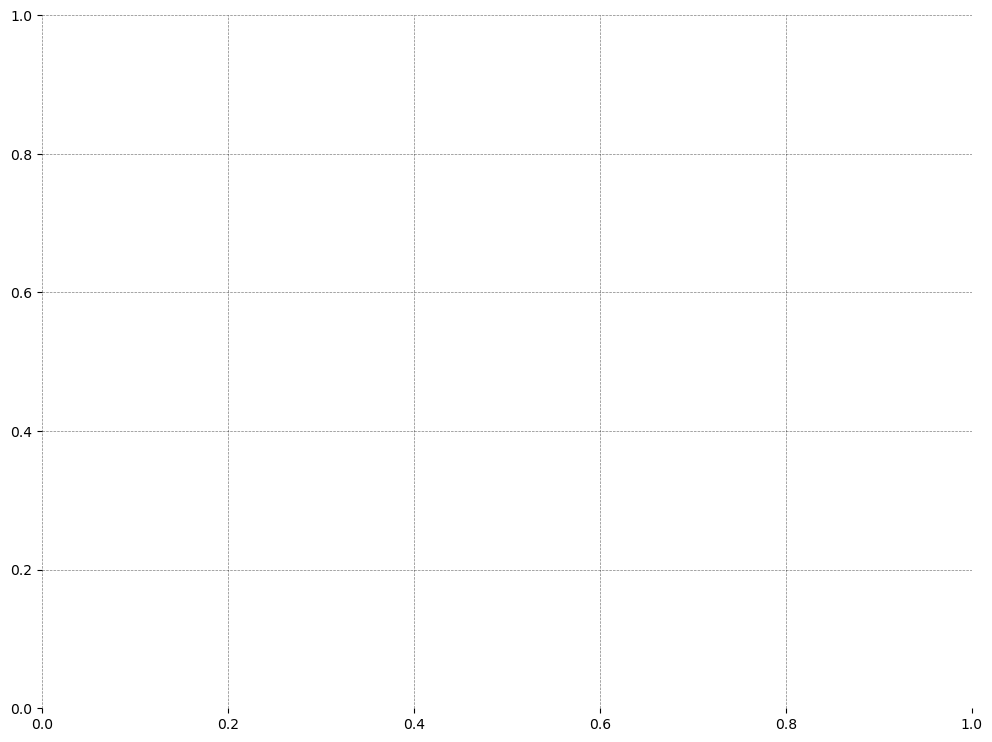

In [24]:
fig = plt.figure(figsize=(12, 9))
ax = plt.axes()
ax.grid(linewidth = 0.5, color = 'black', alpha = 0.5, linestyle = '--', zorder = 10)
ax.set_frame_on(False)
c = ax.pcolormesh(correlation.norm_radius, correlation.height, dataToPlot, vmin = -1, vmax = 1, cmap = cmap.tempAnoms3())
ax.set_title('Correlation between Normalized Wind and VMax\nAll TC-RADAR Swaths', fontweight = 'bold', loc = 'left')
ax.set_title('Deelan Jariwala', loc = 'right')
cbar = plt.colorbar(c, orientation='vertical', aspect=50, pad=0.02)
plt.savefig(r"C:\Users\deela\Downloads\tdrWindCorr.png", dpi = 400, bbox_inches = 'tight')
plt.show()

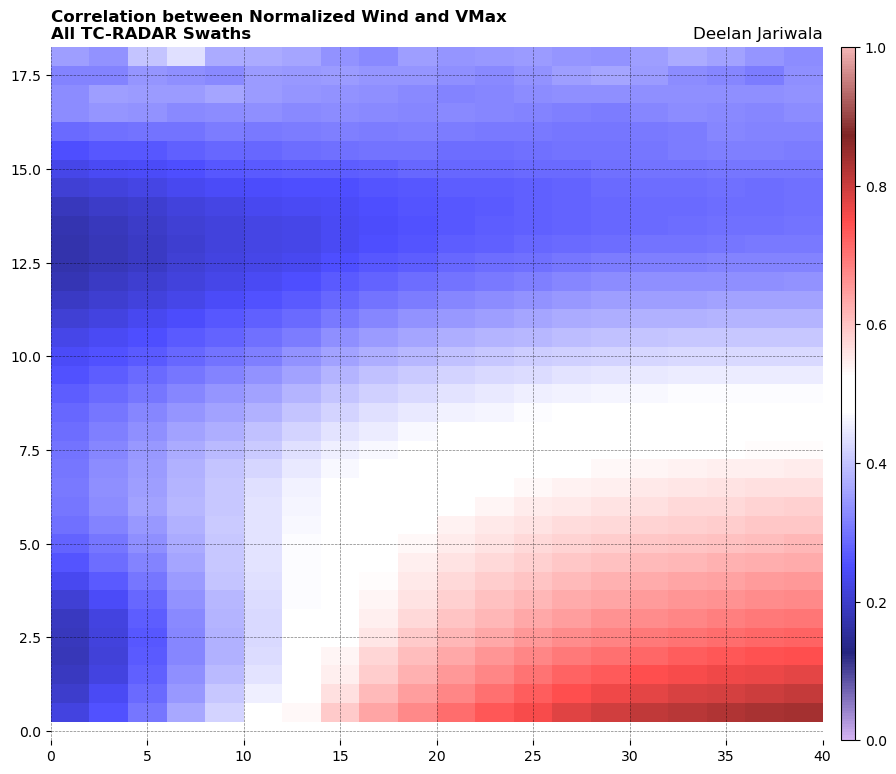

In [12]:
fig = plt.figure(figsize=(12, 9))
ax = plt.axes()
ax.grid(linewidth = 0.5, color = 'black', alpha = 0.5, linestyle = '--', zorder = 10)
ax.set_frame_on(False)
c = ax.pcolormesh(correlation.group_bins, correlation.height, normProfile.mean('num_cases'), vmin = 0, vmax = 1, cmap = cmap.tempAnoms3())
ax.set_title('Correlation between Normalized Wind and VMax\nAll TC-RADAR Swaths', fontweight = 'bold', loc = 'left')
ax.set_title('Deelan Jariwala', loc = 'right')
cbar = plt.colorbar(c, orientation='vertical', aspect=50, pad=0.02)
plt.savefig(r"C:\Users\deela\Downloads\tdrWindCorr.png", dpi = 400, bbox_inches = 'tight')
plt.show()